In [8]:
import numpy as np # 벡터 및 행렬 연산에 있어서 매우 편리한 기능을 제공합니다.
import pandas as pd # dataframe을 다루기 위함.
import glob # 특정 파일 불러오기 (ex .csv .jpg)
import matplotlib.pyplot as plt # 그림그리기 위해 필요한 라이브러리 
import seaborn as sns # 그림그리기 위해 필요한 라이브러리
from datetime import datetime # 날짜를 시계열 타입으로 만들기 위해 필요
import warnings 
from matplotlib import rc, font_manager # 한글폰트를 사용하기 위해 필요
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
rc('font', family ="NanumGothic") # 그림에서 한글폰트를 사용하기위해 필요
import plotly.graph_objs as go
import plotly.offline as pyo

warnings.filterwarnings(action='ignore')
import time # 코드 시간 측정하기 위해 필요

def dekist(Path,limit): #파일이 저장된 경로와 임계치값이 필요
    
    ### 파일 불러오기 단계
    path = Path
    filenames = glob.glob(path+"/*.csv") 
    dfs=[] 
    for filename in filenames:#해당 경로에 있는 csv파일명 모두 리스트에 저장하여 불러옴
        dfs.append(pd.read_csv(filename))#dfs에 csv파일 6개 
    num = len(dfs)
    ### 필요한 열 생성, 기존의 데이터 타입 변경 단계
    for i in range(num):
        dfs[i]['class'] = 0  #필요한 데이터 열을 만들어둠
        dfs[i]['Temp_gap'] = 0
        dfs[i]['Time(sec)'] = 0
        dfs[i]['gradient'] = 0
        Date_time = pd.to_datetime(dfs[i].datetime,format='%Y-%m-%d %H:%M') #측정 시간 타입을 datetime 타입으로 바꿈
        dfs[i]['datetime'] = Date_time
        dfs[i] = dfs[i].drop_duplicates(['datetime'])
        #중복되는 데이터가 있어서 아래 기울기 구할때 오류가 발생(inf값 생성이 되어)하여 중복값 제거
    
    ### 기존 데이터를 이용해 필요한 데이터 생성단계
    A = []
    name = []
    dfs2 = dfs.copy()
    for i in range(num):
        dfs[i]['class'].iloc[:-1]= list(map(lambda x,y:'cold' if x > y else 'warm', dfs[i].value.iloc[:-1],dfs[i].value.iloc[1:]))
        dfs[i]['Temp_gap'].iloc[:-1]= list(map(lambda x,y:y-x if x > y else y-x, dfs[i].value.iloc[:-1],dfs[i].value.iloc[1:]))
        dfs[i]['Time(sec)'].iloc[:-1]= (
            list(map(lambda x,y:(y-x).seconds if x > y else (y-x).seconds, dfs[i].datetime.iloc[:-1],dfs[i].datetime.iloc[1:])))
        dfs[i]['gradient'].iloc[:-1]= list(map(
            lambda x,y:x/y if x > y else x/y, dfs[i].Temp_gap.iloc[:-1],dfs[i]['Time(sec)'].iloc[:-1]))
        dfs[i] = dfs[i].iloc[:-1,:] # 마지막 측정온도는 더이상 비교할 다음 측정기록이 없으므로 삭제
        A.append(dfs[i].groupby('class').mean().gradient) # 각 장비의 기울기
        name.append('equipment{}'.format(i+1)) # 각 장비 번호 순서
    Performance = pd.concat(A,axis=1)  # 각 장비의 기울기들을 한곳에 합침
    Performance.columns = name #새로운 데이터프레임 생성후 컬럼 명 변경
    
    ### 최고/최저/평균온도를 새로운 데이터프레임에 추가하는 단계
    max_Temp = [] #최고온도
    min_Temp = [] #최저온도
    mean_Temp = [] #평균온도
    for i in range(num):
        max_Temp.append(dfs[i].value.max())
        min_Temp.append(dfs[i].value.min())
        mean_Temp.append(dfs[i].value.mean())
    Performance.loc['MAX_temp'] = max_Temp
    Performance.loc['MIN_temp'] = min_Temp
    Performance.loc['MEAN_temp'] = mean_Temp
    
    ### 냉장고의 냉각/보온일때 효율을 데이터프레임에 추가하는 단계
    co = Performance.mean(axis=1).values[0] # 냉각 상태 기울기의 평균
    wa = Performance.mean(axis=1).values[1] # 보온 상태 기울기의 평균
    co1 = (Performance.iloc[0]/co *100) - 100 # 냉각 상태일때 평균대비 효율 % ?
    wa1 = -((Performance.iloc[1]/wa *100) - 100) # 보온 상태일때 평균대비 효율 % ?
    Performance.loc['efficient_cold'] = co1
    Performance.loc['efficient_warm'] = wa1
    ### 초당 온도 변화인것을 분당 온도 변화로 변경
    Performance.iloc[0:2] = (Performance.iloc[0:2] * 60).copy() # 분당 온도변화량 
    #Performance.iloc[0:2] = Performance.iloc[0:2]  # 초당 온도변화량 
    print("냉각 성능이 가장 좋은 장비:",Performance.iloc[0][Performance.iloc[0] == Performance.iloc[0].min()].index.values)
    print("냉각 성능이 가장 안좋은 장비:",Performance.iloc[0][Performance.iloc[0] == Performance.iloc[0].max()].index.values)
    print(" ")
    print("보온 성능이 가장 좋은 장비:",Performance.iloc[1][Performance.iloc[1] == Performance.iloc[1].min()].index.values)
    print("보온 성능이 가장 안좋은 장비:",Performance.iloc[1][Performance.iloc[1] == Performance.iloc[1].max()].index.values)

    
    ### 위의 데이터프레임으로 그래프를 그리는 단계
    f = plt.figure(figsize=(13,20))
    ax1 = f.add_subplot(311)
    ax2 = f.add_subplot(312)
    ax3 = f.add_subplot(313)
    
    ax1.barh(np.arange(len(Performance.columns)),Performance.loc['MAX_temp'],
             height=0.25,color='r',tick_label=Performance.columns,label='MAX')
    ax1.barh(np.arange(len(Performance.columns))+0.25,Performance.loc['MIN_temp'],height=0.25,color='b',label='MIN')
    ax1.barh(np.arange(len(Performance.columns))+0.5,Performance.loc['MEAN_temp'],height=0.25,color='g',label='MEAN')
    ax1.set_title("각 장비 최대/최소/평균 온도",fontsize=20)
    ax1.set_xlabel("온도",fontsize=15)
    ax1.set_ylabel("장비",fontsize=15)
    ax1.legend()
    ax1.set_xlim(0,-100)
    ax1.grid(axis='x')
    
    ax2.barh(np.arange(len(Performance.columns)),Performance.loc['cold'],height=0.25,color='b',
             tick_label=Performance.columns,label='cold')
    ax2.barh(np.arange(len(Performance.columns))+0.25,Performance.loc['warm'],height=0.25,color='orange',label='warm')
    ax2.set_title("분당 온도 변화",fontsize=20)
    ax2.set_xlabel("온도",fontsize=15)
    ax2.set_ylabel("장비",fontsize=15)
    ax2.legend()
    ax2.grid(axis='x')
    
    ax3.barh(np.arange(len(Performance.columns)),Performance.loc['efficient_cold'],height=0.25,color='b',
             tick_label=Performance.columns,label='cold')
    ax3.barh(np.arange(len(Performance.columns))+0.25,Performance.loc['efficient_warm'],height=0.25,color='orange',label='warm')
    ax3.set_title("각 장비 효율",fontsize=20)
    ax3.set_xlabel("효율",fontsize=15)
    ax3.set_ylabel("장비",fontsize=15)
    ax3.legend()
    ax3.grid(axis='x')
    plt.xticks(fontsize=13)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    plt.savefig('bar.png',bbox_inches='tight') #현재 파일이 있는 경로에 이미지 파일 저장
    plt.show()
    
    
    # 온도그래프 그리기 
    for i in range(num):
        start = time.time()
        plt.figure(figsize=(50,10))
        col = np.where(dfs[i].value > limit[i],'r','m') # 임계치가 넘으면 color : red, 아닐땐 purple
        plt.plot(dfs[i].datetime,dfs[i].value,alpha=0.7,linewidth = 0.7)
        plt.axhline(limit[i],color='red') #임계치 수평선 
        plt.scatter(dfs[i].datetime,dfs[i].value,c=col,s=10) # 임계치가 넘는 부분은 빨간 점으로 표시
        plt.title('equipment{}'.format(i+1),fontsize=50)
        plt.xlabel('시간',fontsize=30)
        plt.ylabel('온도',fontsize=30)
        
        plt.savefig('graph{}.png'.format(i+1),bbox_inches='tight') #현재 파일이 있는 경로에 이미지 파일 저장
        plt.show()
        print(time.time() - start)
    #6번째 파일 8월25일~9월1일 전까지의 데이터가 없어서 붕떠보임
    

    
    ### 데이터프레임에 임계치 초과 일수 추가하는 단계
    boo=[] #임계치 초과 횟수 담기
    day = []
    for i in range(num):
        d = dfs[i][dfs[i].value > limit[i]]
        boo.append(len(d))
        c = d.datetime.dt.strftime('%Y-%m-%d %H:%M')
        day.append(len(c.str.split(" ").str[0].unique()))
    Performance.loc['exceed'] = boo
    #Performance.loc['exceed'].astype(int)
    Performance = Performance.transpose()
    Performance.exceed = Performance.exceed.astype(int)
    Performance['exceed_day'] = day
    
    # 위에 초과 횟수를  (초과횟수/총측정횟수)로 바꿔서 그래프로 그림
    # 초과 일수를 (초과일수/총측정일수)로 바꿔서 그래프로 그림
    n = [] #각 장비별 총 측정 횟수
    k = [] #각 장비별 총 측정 일수
    for i in range(num):
        n.append(len(dfs[i]))
        a = dfs[i].datetime.dt.strftime('%Y-%m-%d %H:%M')
        k.append(len(a.str.split(" ").str[0].unique()))
   
    
    # 임계치 초과 횟수 그래프 그리기
    f = plt.figure(figsize=(8,10))
    ax1 = f.add_subplot(211)
    ax2 = f.add_subplot(212)
    sns.barplot(x = Performance.index,y = Performance.exceed, ax = ax1)
    ax1.set_title('장비별 임계치 초과 횟수',fontsize=15) # 6번째 파일이 1~5월이 비어있어서 횟수,일수가 상대적으로 낮음
    ax1.set_xlabel('장비')
    ax1.set_ylabel('횟수')
    
    sns.barplot(x = Performance.index,y = Performance.exceed / n * 100,ax = ax2)
    ax2.set_title('장비별 임계치 초과 횟수',fontsize=15)
    ax2.set_xlabel('장비')
    ax2.set_ylabel('%')
    

    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.savefig('exceed_count.png',bbox_inches='tight')
    plt.show()
   
    # 임계치 초과 일수 그래프 그리기 
    f = plt.figure(figsize=(8,10))
    ax1 = f.add_subplot(211)
    ax2 = f.add_subplot(212)
    
    
    sns.barplot(data=Performance.reset_index(),x='index',y='exceed_day',ax = ax1)
    ax1.set_title('장비별 임계치 초과 일수',fontsize=15)
    ax1.set_xlabel('장비')
    ax1.set_ylabel('일수')

    sns.barplot(x = Performance.index,y = Performance.exceed_day / k * 100,ax = ax2)
    ax2.set_title('장비별 임계치 초과 일수',fontsize=15)
    ax2.set_xlabel('장비')
    ax2.set_ylabel('%')
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.savefig('exceed_day.png',bbox_inches='tight')
    plt.show()
    
    # 시간 구하기 
    tt=[] # 각 장비의 임계치 초과시간 담을 리스트
    
    for j in range(num):
        start =[] # start는 임계치 초과 영역의 시작 지점
        end =[]  # end는 임계치 초과 영역의 끝 지점
        one = 0 # 임계치 초과된 측정이 한번만 있는 경우 시간을 저장할 변수
        many = 0 # 임계치 초과된 측정이 연속적으로 있는 경우 시간을 저장할 변수
        d = dfs2[j][dfs2[j].value > limit[j]].copy() # 각 장비별로 측정시 임계치가 넘는 부분만 데이터프레임(d) 에 저장
        start.append(d.iloc[0].name) # d의 첫번째 행의 name start에 첫번째로 저장
        for i in range(len(d)-1):
            if d.iloc[i+1].name - d.iloc[i].name != 1:
                start.append(d.iloc[i+1].name)
                end.append(d.iloc[i].name)
            else:
                pass
        end.append(d.iloc[-1].name) # d의 마지막 행의 name end의 마지막에 저장
        
        li = list(map(lambda x,y: y-x,start,end)) # 연속된 임계치 마지막 값에서 첫번째 값 뺀 측정 저장 
        for i in li:
            if i==0:
                one += 10
            else:
                many += i * 10
        tt.append((one+many)/60)
    Performance['exceed_time'] = tt
    Performance['exceed_time/exceed'] = Performance.exceed_time / Performance.exceed * 60
        
#         m = []
#         o = []
#         c = d.datetime.dt.strftime('%Y-%m-%d %H:%M') # 위에서 만든 데이터프레임의 시간 타입을 str형태로 바꿈
#         d.datetime = c.str.split(" ").str[0] # str로 바꾼 시간을 연/월/일 까지 자르고 데이터프레임의 datetime열에 변경/저장
#         o.append(len(d.groupby('datetime').count().value[d.groupby('datetime').count().value == 1])*10) # 각 장비별 임계치 초과 측정 횟수가 1회일때의 개수를 구하고 거기에 10을 곱하여 1회일때는 10분이라고 가정
        #####
#         cc = dfs[i]['Time(sec)'].mean() * 1.5 ######### 이부분은 두 측정간 시간차이가 많이 날때 정해야함
#         #####
#         m.append(sum(list(map(lambda x,y: (x - y).seconds /60 if (x-y).seconds <= cc and (x-y).days <=1 else 0,
#                               dfs2[j][dfs2[j].value>limit[j]].datetime.iloc[1:],
#                               dfs2[j][dfs2[j].value>limit[j]].datetime.iloc[:-1]))))
             
#         #m.append(b) # b에 담긴 값을 a에 저장 각 장비별로 나타남
#         m[j] = round((m[j] + o[j]) / 60,2) 
        # m리스트에 다시 각 장비별 임계치 초과 시간을 o리스트의 초과 시간과 더해서 시간으로 나타냄
#    Performance['exceed_time'] = o # Performance라는 데이터프레임에 'exceed_time' 열에 m리스트의 값을 저장
    
    
    measure = [] # 장비당 총 측정 시간 담는 리스트(Time을 전부 더한값)
    hour = [] # 초과 시간/총 측정 시간 을 담는 리스트
    for i in range(num):
        #fulltime = len(dfs[i].value)-1
        measure.append(round(dfs[i]['Time(sec)'].sum()/60,2)) # 장비별 총측정 시간에 곱하기 60을 해서 분으로 바꿈 
        hour.append(Performance.exceed_time[i] / measure[i] * 100) # 초과 시간/ 총 측정 시간 *100을 하여 %로 나타냄
    
    # 임계치 초과 시간 그래프 그리기
    f = plt.figure(figsize=(8,10))
    ax1 = f.add_subplot(2,1,1)
    ax2 = f.add_subplot(2,1,2)
    
    sns.barplot(x = Performance.index,y = Performance.exceed_time,ax = ax1)
    ax1.set_title('장비별 임계치 초과 시간',fontsize=15)
    ax1.set_xlabel('장비')
    ax1.set_ylabel('시간')

    sns.barplot(x = Performance.index,y = hour,ax=ax2)
    ax2.set_title('장비별 임계치 초과 시간',fontsize=15)
    ax2.set_xlabel('장비')
    ax2.set_ylabel('%')
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    plt.savefig('exceed_times.png',bbox_inches='tight')
    plt.show()
    
    K = 273.15 # KELVIN
    T = 10000 # (활성화 함수/ 기체상수)  => 활성화함수는 83.144 KJ/mol로 고정 기체상수는 0.0083144
    M =[] # 최저 온도와 최고 온도를 가지고 평균온도를 담을 리스트
    MKT=[] # MKT값을 담는 리스트
    for i in range(len(dfs2)):
        dfs2[i].datetime = dfs2[i].datetime.dt.strftime('%Y-%m')
        M.append((dfs2[i].groupby('datetime').value.max() + dfs2[i].groupby('datetime').value.min())/2)
        n = len(M[i])
        a = 0 
        for j in M[i]:
            t1 = K + j
            a+= np.exp(-T/t1)
        MKT.append(round(-K +(-T/np.log(a/n)),2))
    
    Performance['MKT'] = MKT
    

    trace = go.Bar(x=Performance.index,y=Performance.MKT) # plotply 라이브러리를 이용하여 시각화
    data=[trace]
    layout=go.Layout(title='MKT')
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(yaxis_range=[0,-100])
    pyo.iplot(fig)
    return Performance,dfs


냉각 성능이 가장 좋은 장비: ['equipment4']
냉각 성능이 가장 안좋은 장비: ['equipment5']
 
보온 성능이 가장 좋은 장비: ['equipment5']
보온 성능이 가장 안좋은 장비: ['equipment4']


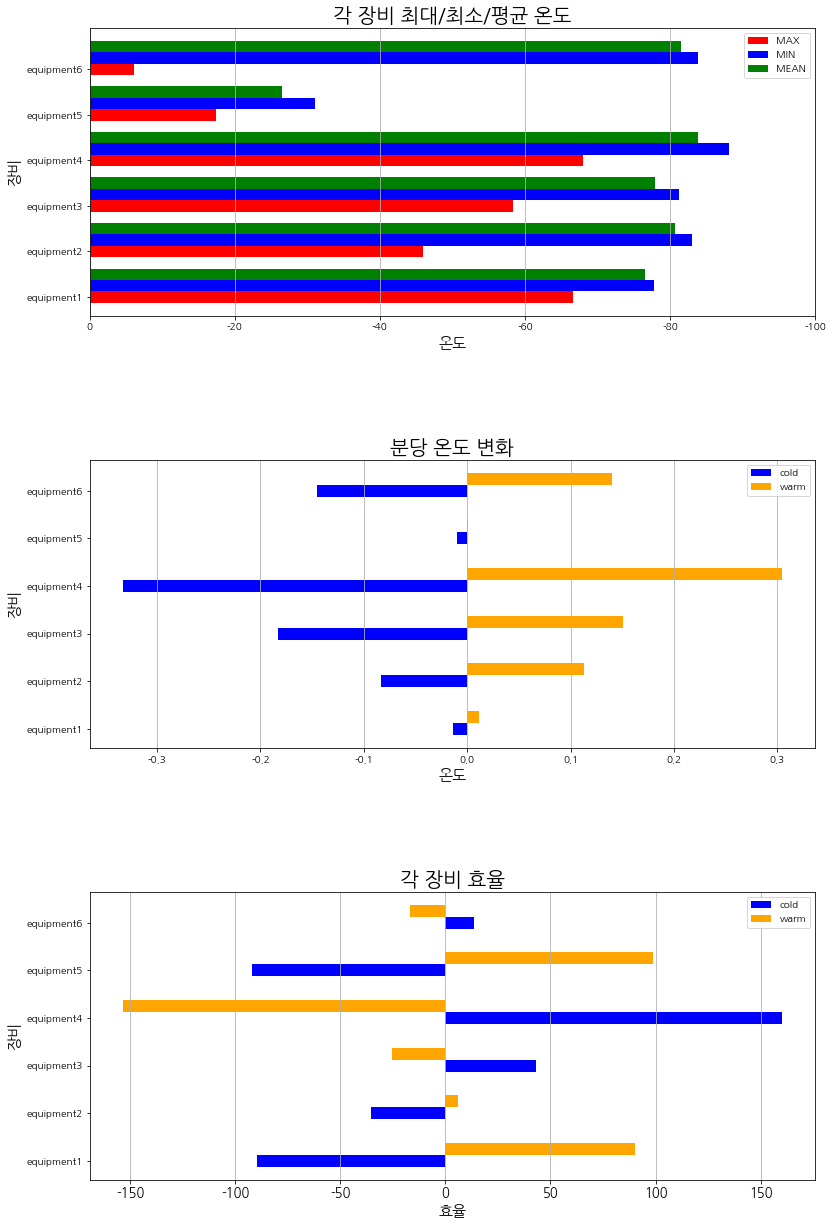

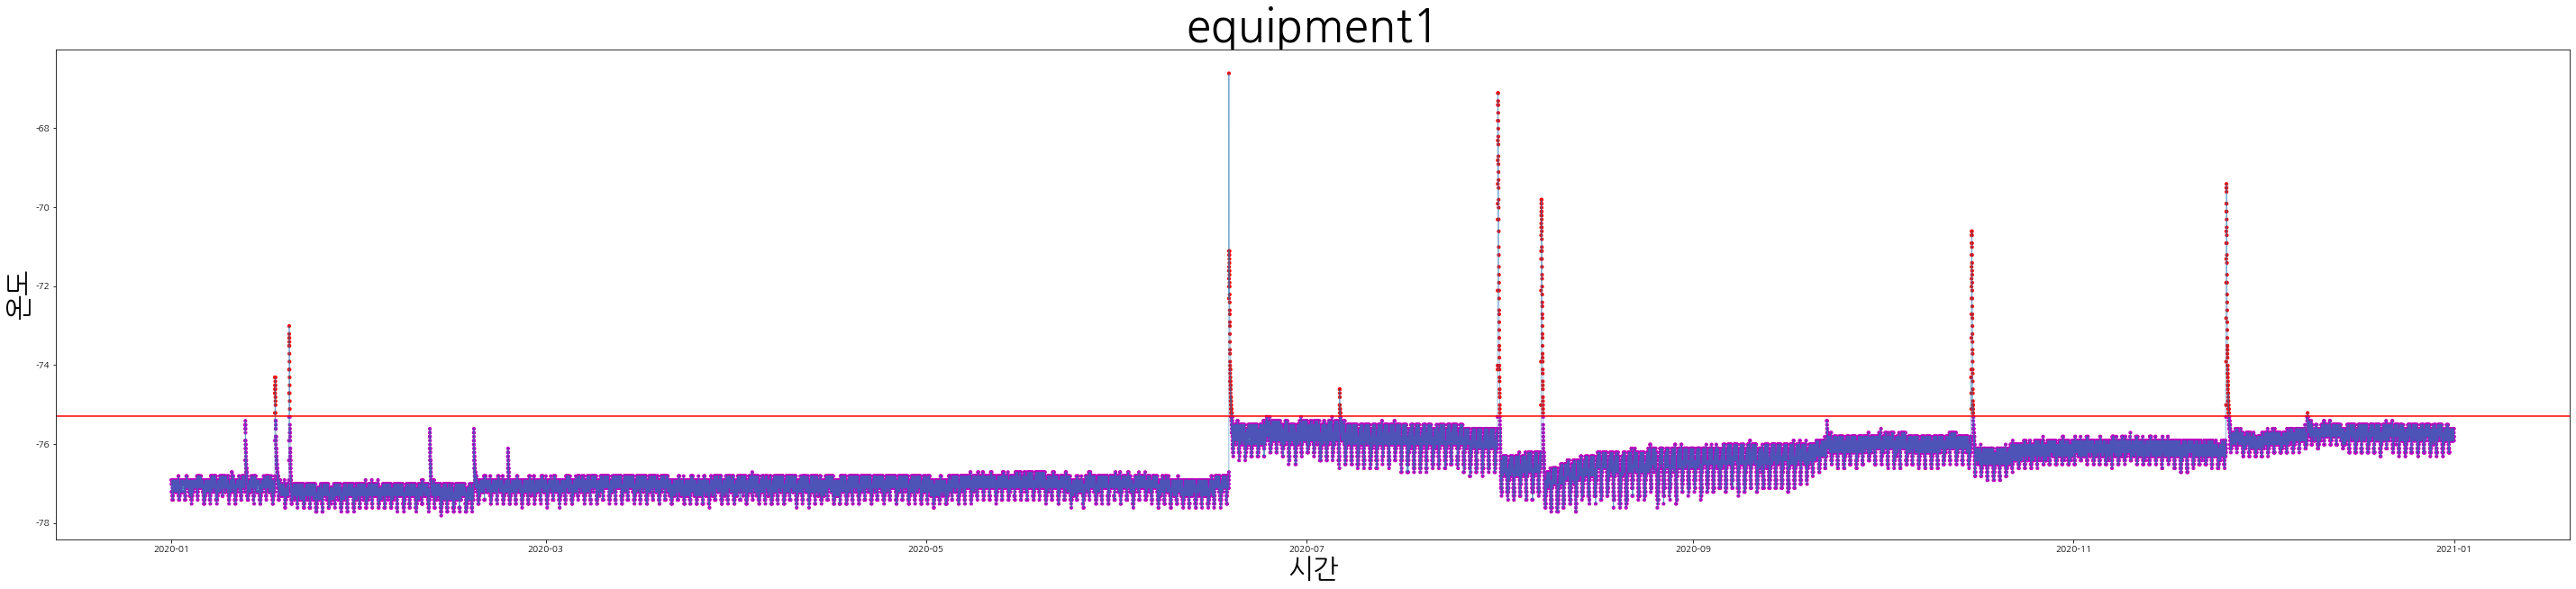

4.928571701049805


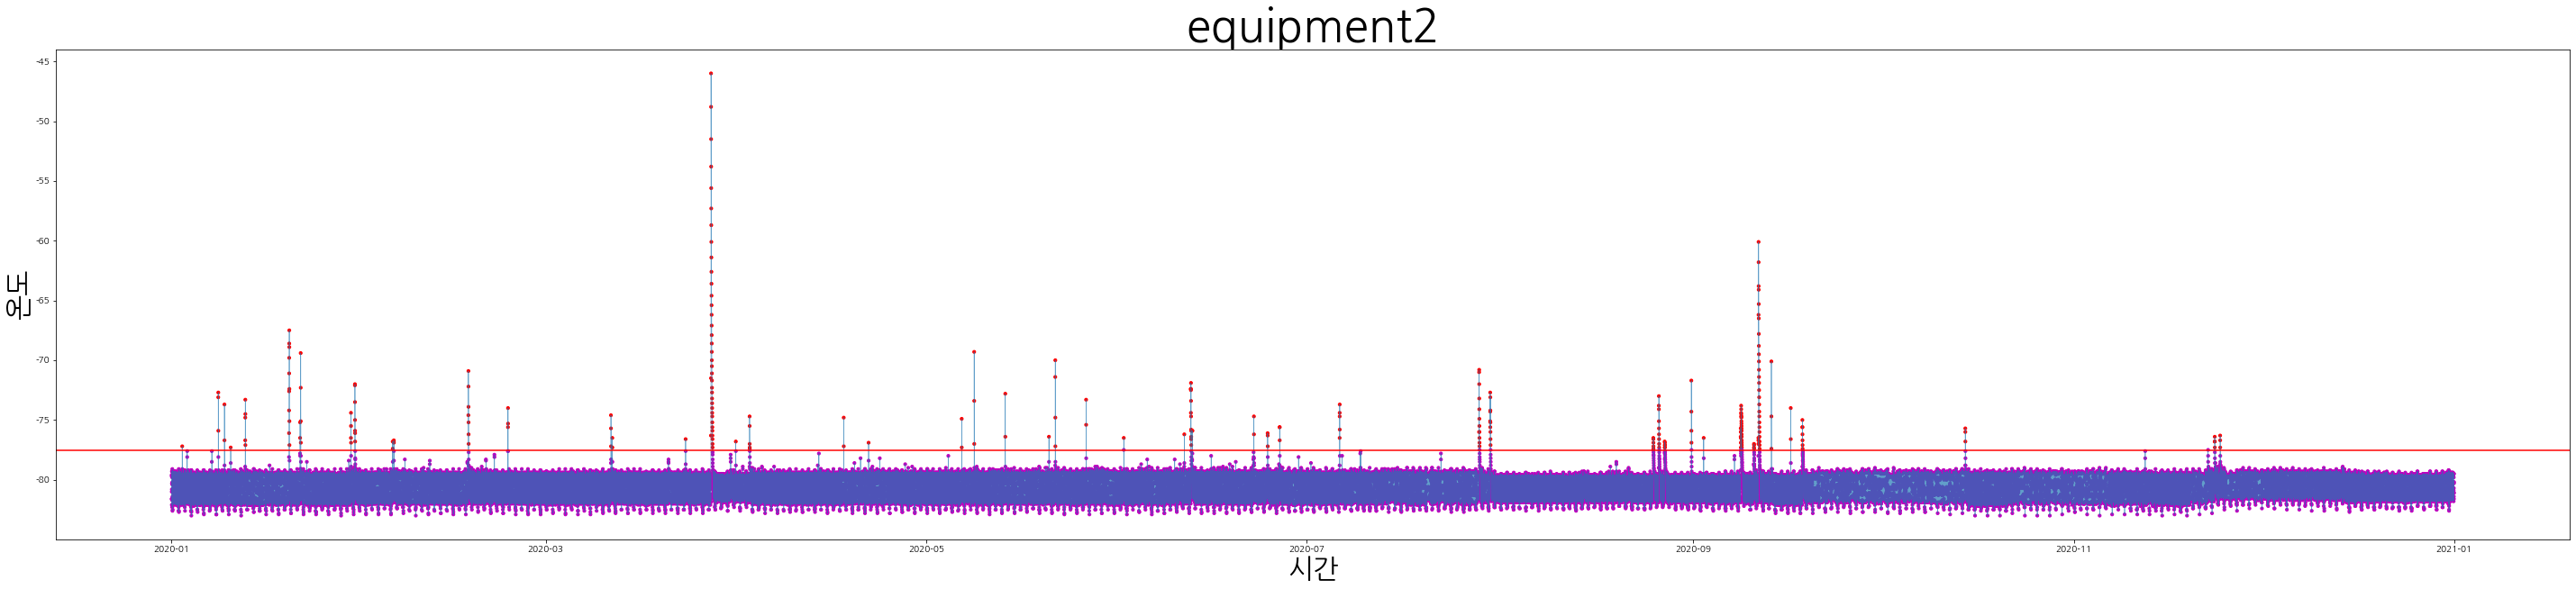

6.166042804718018


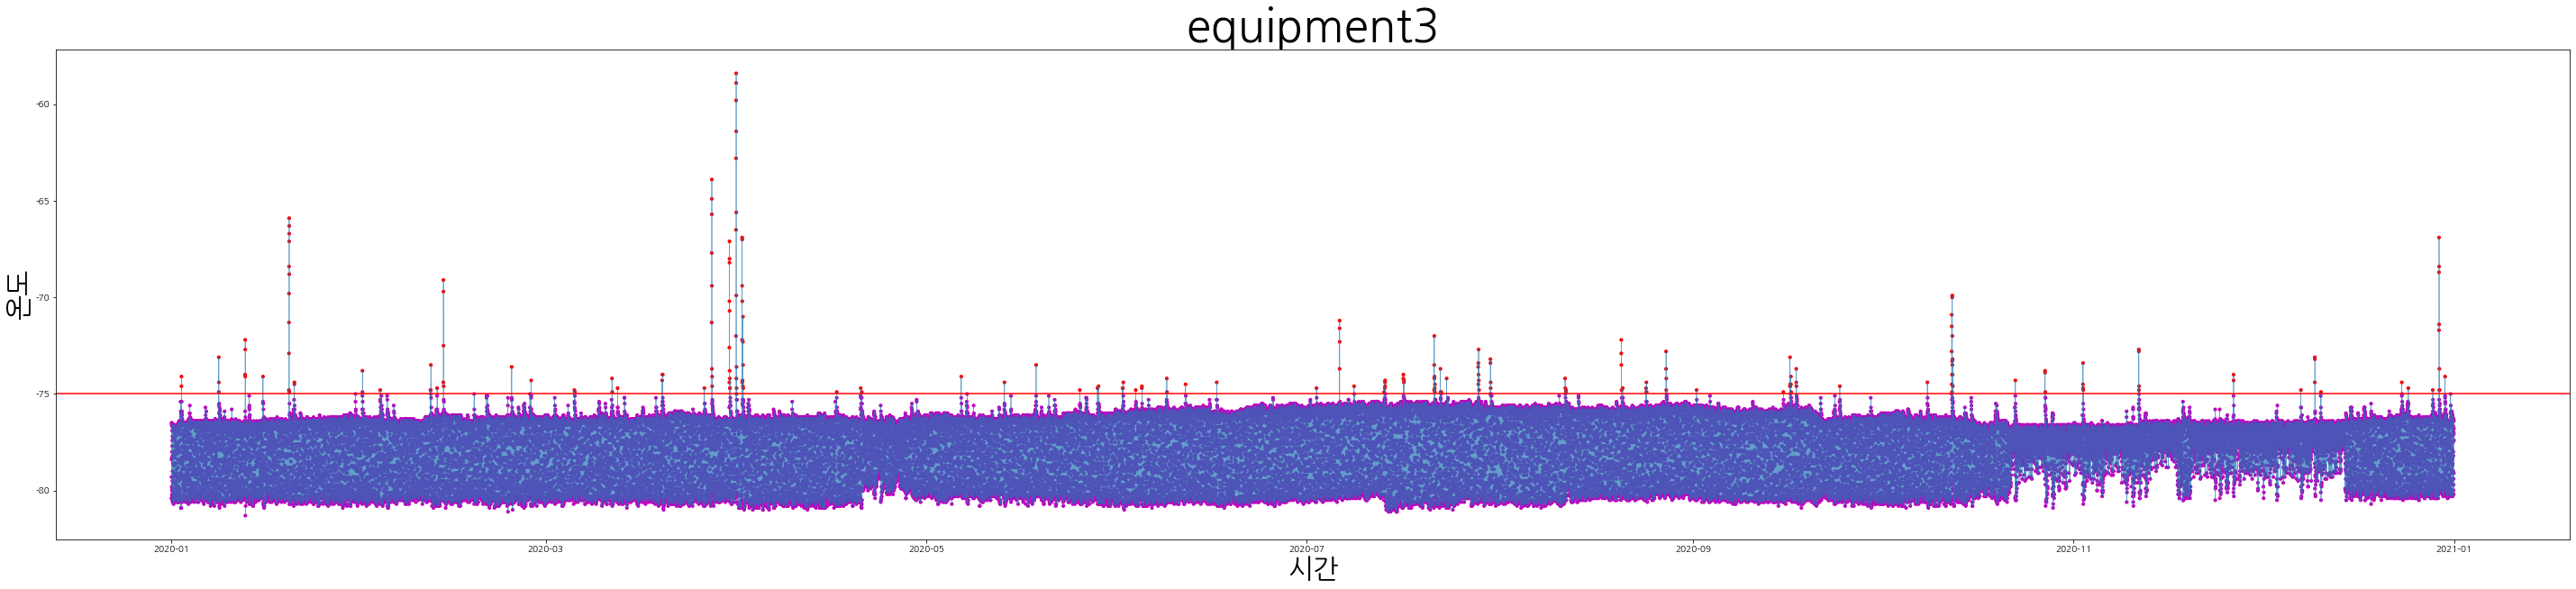

10.227906465530396


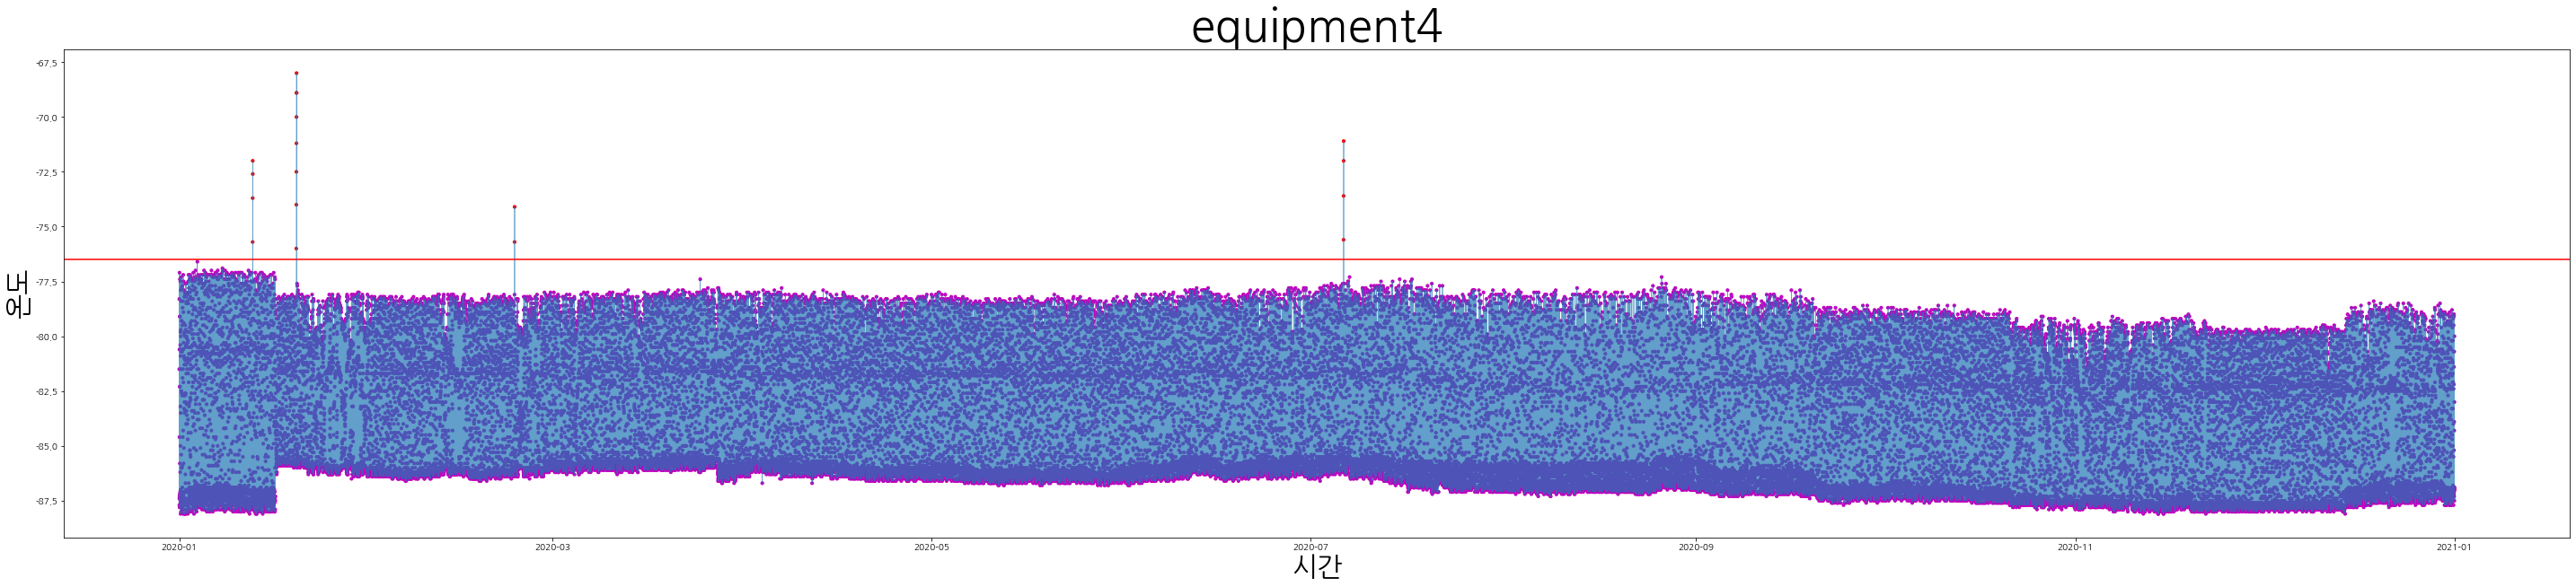

16.521329879760742


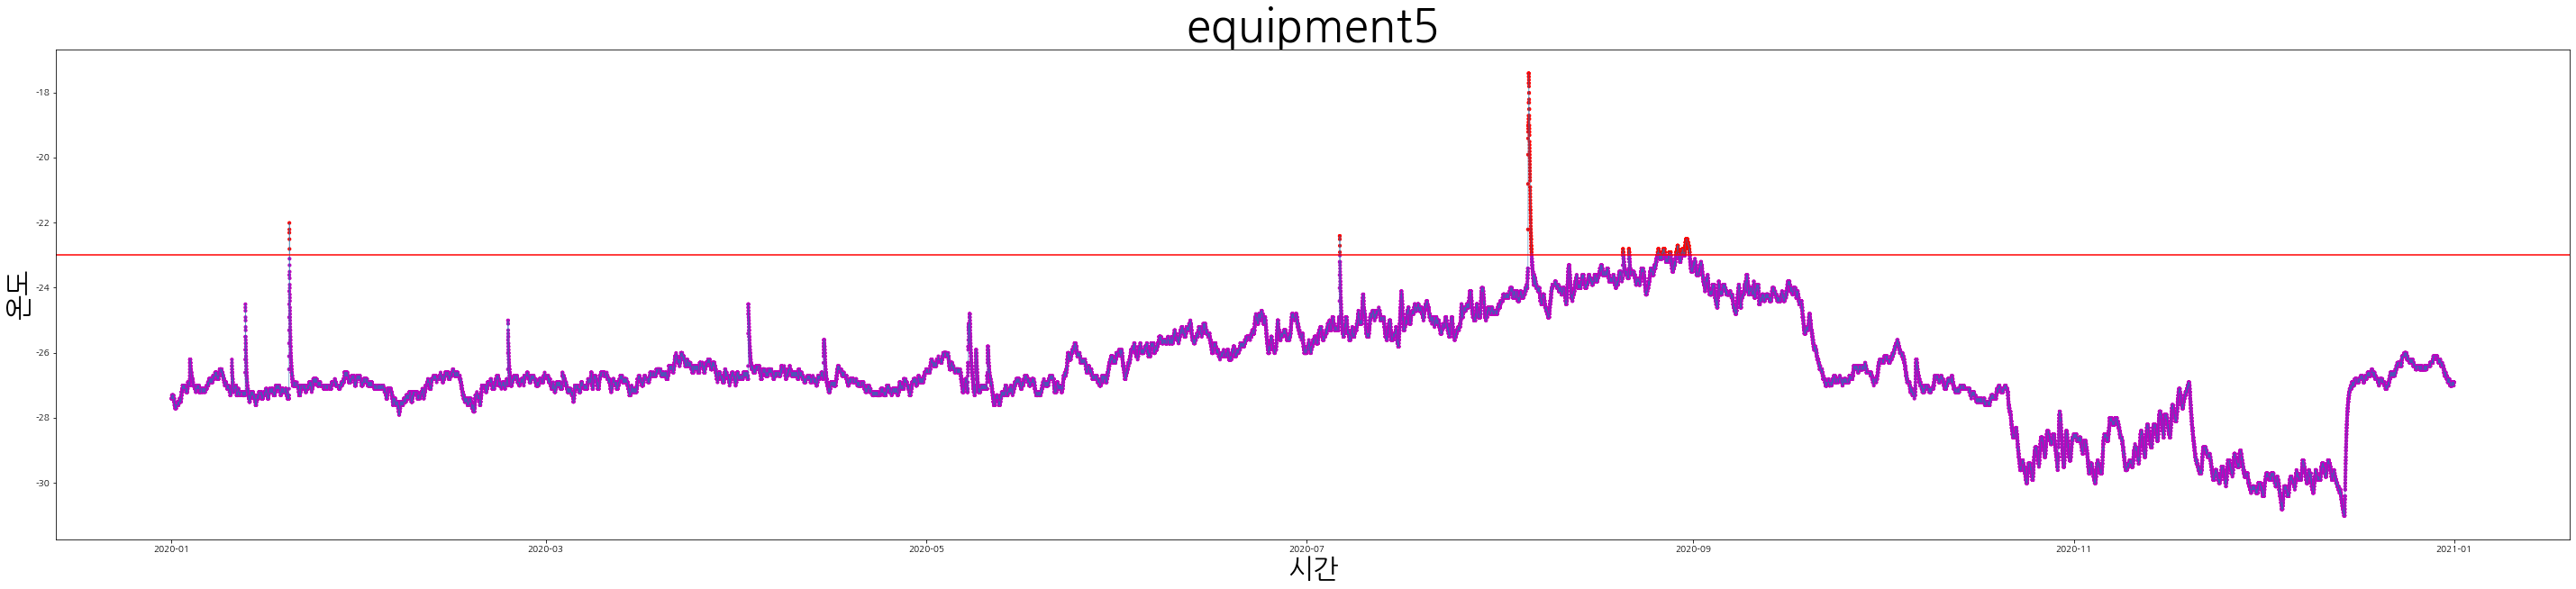

14.293199062347412


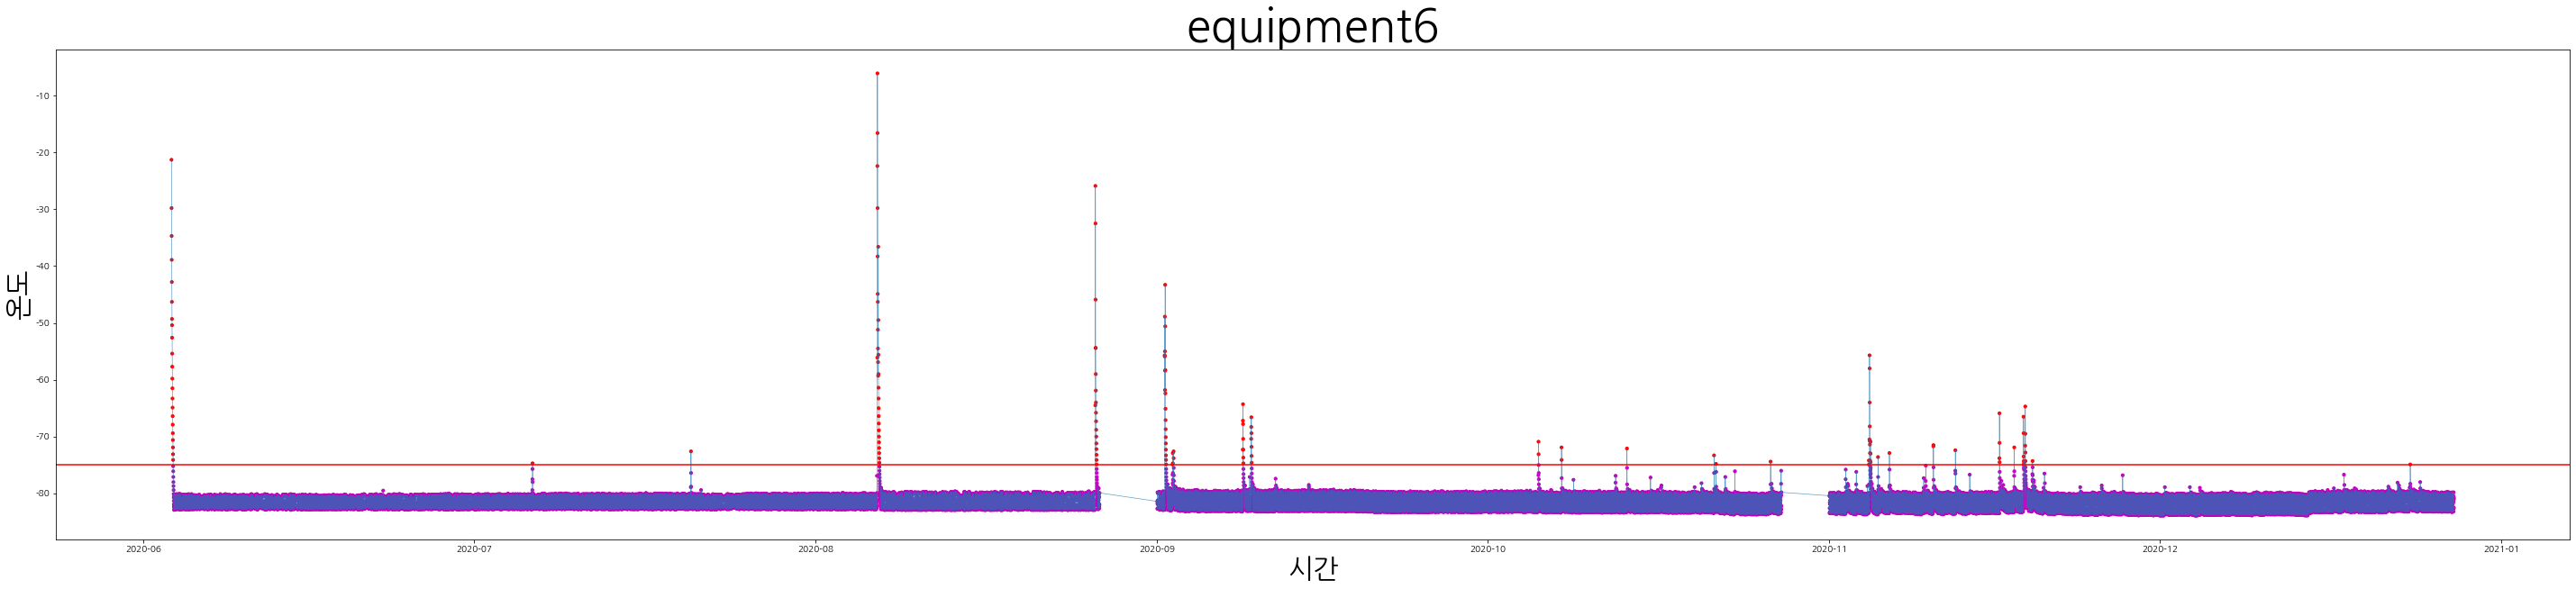

5.373658180236816


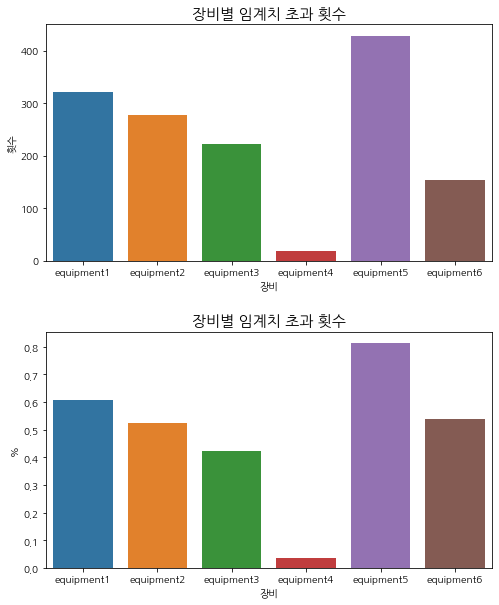

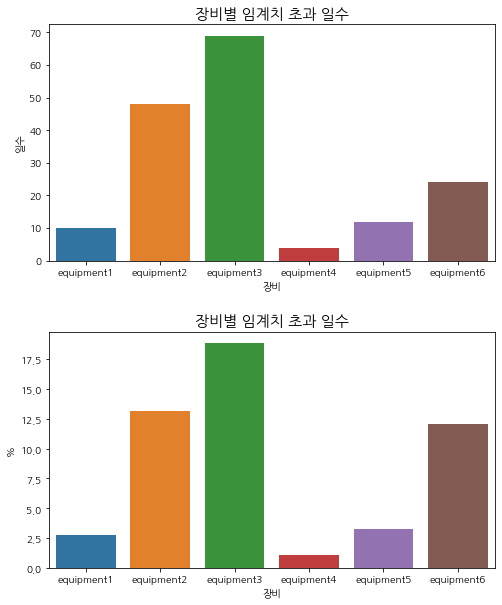

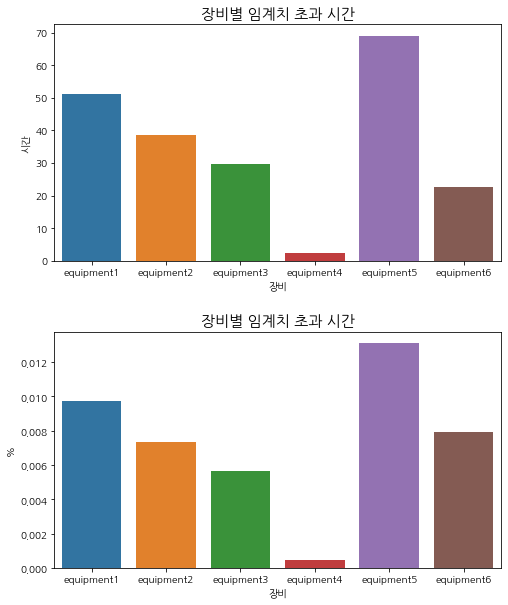

73.27611589431763


In [9]:
import time
#limit = [-75.3,-77.5,-75,-76.5,-23,-75]
st = time.time()
a,c = dekist('C:/Users/wanhu/dekist/dekist',[-75.3,-77.5,-75,-76.5,-23,-75])
print(time.time() - st)

In [4]:
a

class,cold,warm,MAX_temp,MIN_temp,MEAN_temp,efficient_cold,efficient_warm,exceed,exceed_day,exceed_time,exceed_time/exceed,MKT
equipment1,-0.013429,0.011514,-66.61,-77.81,-76.509725,-89.522271,90.415385,321,10,51.333333,9.595016,-74.58
equipment2,-0.083031,0.113001,-46.00,-83.00,-80.667889,-35.217862,5.932195,277,48,38.666667,8.375451,-72.87
equipment3,-0.183331,0.150363,-58.40,-81.30,-77.894341,43.038337,-25.170141,223,69,29.666667,7.982063,-74.56
equipment4,-0.333438,0.304620,-68.00,-88.10,-83.888230,160.153985,-153.581108,18,4,2.333333,7.777778,-81.40
equipment5,-0.010072,0.001191,-17.41,-31.01,-26.527183,-92.141739,99.008782,429,12,69.166667,9.673660,-25.62
equipment6,-0.145715,0.140075,-6.10,-83.90,-81.560401,13.689550,-16.605113,153,24,22.666667,8.888889,-53.17


In [5]:
c

[                 datetime  value class  Temp_gap  Time(sec)  gradient
 0     2020-01-01 00:07:00 -76.91  warm       0.0        600  0.000000
 1     2020-01-01 00:17:00 -76.91  cold      -0.3        600 -0.000500
 2     2020-01-01 00:27:00 -77.21  warm       0.2        600  0.000333
 3     2020-01-01 00:37:00 -77.01  warm       0.1        600  0.000167
 4     2020-01-01 00:47:00 -76.91  warm       0.0        600  0.000000
 ...                   ...    ...   ...       ...        ...       ...
 52714 2020-12-31 23:09:00 -75.61  warm       0.0        600  0.000000
 52715 2020-12-31 23:19:00 -75.61  cold      -0.2        600 -0.000333
 52716 2020-12-31 23:29:00 -75.81  cold      -0.1        600 -0.000167
 52717 2020-12-31 23:39:00 -75.91  warm       0.1        600  0.000167
 52718 2020-12-31 23:49:00 -75.81  warm       0.2        600  0.000333
 
 [52719 rows x 6 columns],
                  datetime  value class  Temp_gap  Time(sec)  gradient
 0     2020-01-01 00:08:00  -81.6  warm       2.